# CANDLESTICK PATTERNS IN TRADING: A Data-Driven Journey

This Jupyter notebook accompanies the Medium article "Candlestick Patterns in Trading: A Data-Driven Journey (Part 2)". It demonstrates the process of acquiring stock data, preprocessing it, identifying candlestick patterns, and conducting a rigorous statistical analysis using Python and various libraries such as yfinance, Plotly, and scipy.

### NECESSARY LIBRARIES

We start by importing the necessary Python libraries for data manipulation, statistical analysis, and visualization.

In [1]:
import plots as pl
import loader as ld
import patterns as pt
import analysis as a
import pandas as pd
import numpy as np
import random
import math
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Note that some of the functions that we already defined in `Pattern_Medium_01.ipynb`here are called from external modules like `loader.py`that you can find in the GitHub repository of this project.

### DATA LOADING and PREPROCESSING

We'll use the `yfinance` library to fetch historical stock data for Apple (AAPL). The data is then cleaned and preprocessed to ensure its quality and consistency.

In [2]:
tickers = 'AAPL'

In [3]:
stock_data = ld.load_data(tickers)
stock_data = ld.check_clean_data(stock_data, verbose=True)

From AAPL dataset were removed 5 rows with missing or incorrect data
Ticker: AAPL has 1 anomalies:
  Open-pClose Anomalies: 1
[(Timestamp('2000-09-29 00:00:00-0400', tz='America/New_York'), 0.4256, 0.8077)]


In [4]:
df = stock_data[tickers]['historical_data']

In [5]:
# add percentage and log returns
df = a.add_pct_log_returns(df)
# create another df with additional indicators
support_df = a.calculate_ATR(df)

This code loads the data, checks for and removes any inconsistencies, and calculates additional metrics like percentage returns, log returns, and the Average True Range (ATR).

### PATTERN IDENTIFICATION

Next, we identify instances of the Bullish Engulfing pattern in our dataset. This pattern is defined in our `patterns.py` module.

In [6]:
pattern_name = "Bullish Engulfing"  # replace with the desired pattern name

# check if the pattern exists in the patterns dictionary
if pattern_name in pt.patterns:
    # get the function and the number of candles of the pattern from the patterns dictionary
    pattern_function = pt.patterns[pattern_name]['function']
    num_candles = pt.patterns[pattern_name]['candles']
    # use the function to obtain the mask of the pattern dates
    pattern_mask = pattern_function(pd.concat([df, support_df], axis=1))
    print(f'The occurrences of {pattern_name} pattern in the dataset are {pattern_mask.sum()}.')
    dim_pattern_sample = pattern_mask.sum()
else:
    print(f"The pattern '{pattern_name}' does not exist.")

The occurrences of Bullish Engulfing pattern in the dataset are 106.


### NOTES

In this Notebook I am going to use Plotly. If you are reading this Notebook via GitHub, I strongly recommend you to do that in your local machine to be able to produce effectively Plotly interactive charts.

In [7]:
# plot patterns over the close prices
#pl.plot_close_with_patterns(df, tickers, mask, pattern_name)

In [8]:
# plot examples of the pattern
#pl.plot_patterns(df, mask, num_candles=num_candles, ticker=tickers, pattern_name=pattern_name)

### CALCULATING RETURNS FOR PATTERN OCCURRENCES

We now calculate the cumulative returns following each pattern occurrence, looking ahead up to 15 days.

In [9]:
# define the number of periods ahead we want to calculate the returns
max_ahead = 15
periods = range(1, max_ahead + 1)
# we are going to store the returns for each period/day in a dictionary
pattern_returns = {period: [] for period in periods}
pattern_log_returns = {period: [] for period in periods}
for i in range(1, len(df) - max(periods) - 1):    # start from 1 since the first row might have NaN
    if pattern_mask.iloc[i]:                # the pattern occurs at this date
        for period in periods:              # calculate the returns for each period
            if i + period < len(df):
                # simple cumulative return formula
                pattern_returns[period].append((df['Close'].iloc[i + period] - df['Close'].iloc[i]) / df['Close'].iloc[i])
                # log cumulative return formula
                
                pattern_log_returns[period].append(np.log(df['Close'].iloc[i + period] / df['Close'].iloc[i]))

In [10]:
print(pattern_returns.keys())       # the different days ahead. we will call them also periods
print(len(pattern_returns[1]))      # the number of occurrences of the pattern. this is the dimension of our sample regarding the pattern
print(pattern_returns[2])           # the list of returns for one specific day ahead

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
106
[0.002756508422664661, -0.013930950938824934, -0.027282266526757516, 0.05728835136855512, -0.026360067302299395, -0.025303110173958875, -0.0430107526881721, -0.05230125523012557, 0.022565320665083124, -0.15517241379310334, -0.08918128654970761, -0.05162174508908179, 0.014832162373146081, 0.05586592178770955, -0.05083179297597047, -0.02009073233959813, -0.11139601139601131, 0.0014295925661186972, 0.033570412517781034, 0.004012611063341967, 0.02104986186028156, -0.01994570990204181, 0.04710500490677139, 0.024524375743163008, 0.15135727995612824, 0.0, -0.048933038999264086, -0.017560363750391952, -0.0746177370030582, 0.02720048899755507, 0.010071942446043175, 0.0013259082471492984, -0.02897373409152462, -0.013567438148443717, -0.003981179876945313, -0.04077933846850933, -0.03813038130381294, -0.07432854465958773, -0.006305170239596475, -0.03474232773595834, -0.026528902541189482, -0.038860872144764164, -0.04903185509056837

In [11]:
# let's also store the rounded returns for a better visualization
pattern_rounded_returns = {k: [round(100*r,3) for r in v] for k, v in pattern_returns.items()}
print(pattern_rounded_returns[2])

[0.276, -1.393, -2.728, 5.729, -2.636, -2.53, -4.301, -5.23, 2.257, -15.517, -8.918, -5.162, 1.483, 5.587, -5.083, -2.009, -11.14, 0.143, 3.357, 0.401, 2.105, -1.995, 4.711, 2.452, 15.136, 0.0, -4.893, -1.756, -7.462, 2.72, 1.007, 0.133, -2.897, -1.357, -0.398, -4.078, -3.813, -7.433, -0.631, -3.474, -2.653, -3.886, -4.903, 3.635, -3.578, 8.845, 3.071, 0.639, 1.783, -0.281, 1.926, 1.326, 0.53, -3.681, 4.202, -0.307, -6.267, -0.932, 2.818, -2.598, -8.049, 7.527, -8.62, -2.899, 1.961, 6.703, 0.902, 4.709, 2.384, 1.114, 1.189, 2.827, 1.588, 0.454, 0.595, -1.881, 0.3, 1.133, -2.189, -3.195, 1.392, 1.324, 0.292, -2.041, -4.647, -0.985, 1.221, 0.131, -0.18, -0.771, 1.215, -0.221, -4.839, -0.944, 1.143, 2.954, 2.349, 0.386, 1.053, 0.63, -3.132, -0.49, -0.41, -2.445, -0.925, -1.672]


In [12]:
print(pattern_log_returns.keys())
print(len(pattern_log_returns[1]))
print(pattern_log_returns[2])

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
106
[0.002752716220548768, -0.01402889735764235, -0.027661338088346817, 0.055707471357673795, -0.026713722642844884, -0.0256287385478894, -0.043963123421116176, -0.05371860700842195, 0.02231449018540404, -0.16862271243579258, -0.0934113988350973, -0.05300185323708371, 0.014723241552893875, 0.05436120921888743, -0.0521692494778687, -0.02029529562368247, -0.11810359985210812, 0.0014285716715259137, 0.03301922797643665, 0.004004582010712819, 0.020831374288098302, -0.020147310792794245, 0.04602921807902859, 0.02422848123286795, 0.14094148987551297, 0.0, -0.05017080776855939, -0.017716376057865853, -0.07754836954299793, 0.02683713000246798, 0.01002155846101897, 0.0013250300070341838, -0.029401760687485106, -0.01366031687843223, -0.003989125870182258, -0.0416341351218713, -0.03887636900249944, -0.07723590714068244, -0.006325131776968814, -0.0353601953958846, -0.026887143918466302, -0.039636106447685684, -0.050274713412662604, 0.0

### CALCULATING METRICS FOR PATTERN CASE

We compute key metrics for our pattern returns: average return, median return, standard deviation, and win rate.

In [13]:
# here period are the different days ahead while ret are the lists of cumulative returns for that specific day
avg_lin_return = {period: round(sum(ret) / len(ret) * 100, 3) for period, ret in pattern_returns.items() if ret}
median_lin_return = {period: round(np.nanmedian(ret) * 100, 3) for period, ret in pattern_returns.items() if ret}
std_lin_return = {period: round(np.std(ret) * 100, 3) for period, ret in pattern_returns.items() if ret}
win_lin_rate = {period: round(sum(1 for r in ret if r > 0) * 100 / len(ret), 2) for period, ret in pattern_returns.items() if ret}

In [14]:
def log_to_simple(log_return):
    return (np.exp(log_return) - 1) * 100

# Calculate metrics using log returns, then convert to linear scale
avg_log_return = {period: round(log_to_simple(np.mean(ret)), 3) 
              for period, ret in pattern_log_returns.items() if ret}
median_log_return = {period: round(log_to_simple(np.median(ret)), 3) 
                 for period, ret in pattern_log_returns.items() if ret}
std_log_return = {period: round(log_to_simple(np.std(ret)), 3) 
              for period, ret in pattern_log_returns.items() if ret}
# Win rate doesn't need conversion as it's based on the sign, which is the same for log and simple returns
win_log_rate = {period: round(sum(1 for r in ret if r > 0) * 100 / len(ret), 2) 
            for period, ret in pattern_log_returns.items() if ret}

It's important to note that with a sample size of around 100, we can't make statistically significant statements about the k-th distribution or its metrics. Our calculations provide the best point estimates we can obtain for our candlestick pattern.

### GENERATING BASE CASE

To evaluate the effectiveness of our pattern, we need a point of comparison. We create a base case using random entry signals, allowing us to check whether the metrics from our pattern case differ significantly from random chance.

Given our extensive dataset spanning 30 years (approximately 7,000 daily records), we can construct a robust base case that will enable us to make statistically significant statements.

We generate 1,000 samples, each containing a number of random entry dates comparable to the number of actual pattern occurrences. This approach allows us to build a comprehensive picture of what returns look like under random conditions.

In [15]:
n = len(df)
all_indices = list(range(1,n))      # avoid index 0 for Nan values
# Define the size of the sample: we want to have at least 100 samples and we want it to be a multiple of 50
floor = 100
if dim_pattern_sample <= floor:
        dim_sample = floor
else:
    dim_sample = math.ceil(dim_pattern_sample / 50) * 50

def generate_random_mask(length = n, pattern_mask = pattern_mask, dim_sample = dim_sample): 
    '''
    Function to generate a random mask of the same length as the input_mask, with dim_sample True values.
    '''
    
    # When we choose randomly the new dates, we want to exclude the dates where the true pattern occurs
    # Convert input_mask's timestamps to indices
    true_indices = pattern_mask[pattern_mask].index
    true_indices = df.index.get_indexer(true_indices)

    # Exclude indices from true_indices
    available_indices = [idx for idx in all_indices if idx not in true_indices]

    # Random sampling of the available indices
    valid_samples = random.sample(available_indices, dim_sample)

    neutral_mask = pd.Series([False] * length)
    neutral_mask.iloc[valid_samples] = True

    return neutral_mask

# Test the function to check how many dates are selected
generate_random_mask().sum()

150

Let's create 1000 random masks!

In [16]:
n_iterations = 1000
random_masks = [generate_random_mask() for _ in range(n_iterations)]

Let's calculate the cumulative returns for each of the random mask just created

In [17]:
basecase_returns = []
basecase_log_returns = []
max_ahead = 15
periods = range(1, max_ahead + 1)

for mask in random_masks:
    # initialize the dictionary of cumulative returns for each mask
    returns = {period: [] for period in periods}
    log_returns = {period: [] for period in periods}
    for i in range(1, len(df) - max(periods) - 1):
        if mask.iloc[i]:
            for period in periods:
                if i + period < len(df):
                    # simple cumulative return formula
                    returns[period].append((df['Close'].iloc[i + period] - df['Close'].iloc[i]) / df['Close'].iloc[i])
                    # log cumulative return formula
                    log_returns[period].append(np.log(df['Close'].iloc[i + period] / df['Close'].iloc[i]))

    #rounded_returns = {k: np.array([round(100*r,3) for r in v]) for k, v in returns.items()}      # round to 3 decimal places
    rounded_returns = {k: np.array(v) for k, v in returns.items()}
    log_returns = {k: np.array(v) for k, v in log_returns.items()}
    basecase_returns.append(rounded_returns)
    basecase_log_returns.append(log_returns)

basecase_returns is a list of 1000 dictionaries each containing the cumulative returns related to the k-th day after the entry.

In [18]:
print(len(basecase_returns))
print(basecase_returns[0].keys())
print(len(basecase_returns[0][2]))
print(type(basecase_returns[0][2]))

1000
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
150
<class 'numpy.ndarray'>


In [19]:
print(len(basecase_log_returns))
print(basecase_log_returns[0].keys())
print(len(basecase_log_returns[0][2]))
print(type(basecase_log_returns[0][2]))

1000
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
150
<class 'numpy.ndarray'>


### CALCULATE BASE CASE METRICS

For each random sample in our base case, we calculate the same metrics as we did for our pattern case. This process results in obtaining the full distributions of these metrics, providing a more complete picture of typical stock behavior.

In [20]:
n_days = len(basecase_returns[0])

# Initialize the results dictionary
basecase_metrics = {
    'win_rate': {},
    'average_return': {},
    'median_return': {},
}

# Loop over the days
for day in range(1, n_days + 1):
    win_rates = []
    avg_returns = []
    median_returns = []
    # Loop over all the samples
    for sample in basecase_log_returns:     # you can use basecase_log_returns to get the log returns
        day_returns = sample[day]
        
        # Calculate win rate
        win_rate = (day_returns > 0).sum() / len(day_returns) * 100
        win_rates.append(win_rate)
        
        # Calculate average return
        avg_return = np.mean(day_returns)
        avg_returns.append(avg_return)
        
        # Calculate median return
        median_return = np.median(day_returns)
        median_returns.append(median_return)

    
    # Store the results for this day
    basecase_metrics['win_rate'][day] = np.array(win_rates)
    basecase_metrics['average_return'][day] = np.array(avg_returns)
    basecase_metrics['median_return'][day] = np.array(median_returns)

As you can see, basecase_metrics is a dictionary where metrics are stored as nested dictionaries with each k-th day as key and metric value as values

In [21]:
print(basecase_metrics.keys())
print(basecase_metrics['win_rate'].keys())
print(basecase_metrics['win_rate'][1].shape)

dict_keys(['win_rate', 'average_return', 'median_return'])
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
(1000,)


For each objective metric we have a significant (1000 observations from the original time series) distribution of factual returns coming from the original time series for each of the k day ahead we are interested in. 

### VISUALISING METRIC DISTRIBUTIONS

Next, we analyze the distributions of our calculated metrics. We're particularly interested in understanding if these distributions resemble normal distributions, as this will inform our choice of statistical tests later.

We create visualizations (histograms and Q-Q plots) for each metric and each day. This allows us to visually assess the shape of our distributions

In [22]:
# Histograms of the metric distributions for each day
metric_name = 'average_return'
metric_data = basecase_metrics[metric_name]
num_days = len(metric_data)
num_cols = 3
num_rows = (num_days + num_cols - 1) // num_cols

fig = make_subplots(rows=num_rows, cols=num_cols,
                    subplot_titles=[f"{metric_name} after {day} days" for day in metric_data.keys()],
                    vertical_spacing=0.1)

for idx, (day, values) in enumerate(metric_data.items()):
    row = idx // num_cols + 1
    col = idx % num_cols + 1
    
    # Calculate histogram data
    hist, bin_edges = np.histogram(values, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot histogram
    fig.add_trace(go.Bar(x=bin_centers, y=hist, name='', showlegend=False,
                            hoverinfo='x'),
                    row=row, col=col)
    
    # Fit a normal distribution to the data
    mu, std = np.mean(values), np.std(values)
    x = np.linspace(min(values), max(values), 100)
    p = stats.norm.pdf(x, mu, std)
    
    # Plot the normal distribution
    fig.add_trace(go.Scatter(x=x, y=p, mode='lines', name='Normal Distribution',
                                line=dict(color='red'), showlegend=False,
                                hoverinfo='name'),
                    row=row, col=col)
    
    # Update axes labels
    fig.update_xaxes(title_text=None, row=row, col=col)
    fig.update_yaxes(title_text=None, row=row, col=col)
    
    # Center the x-axis range
    fig.update_xaxes(range=[np.percentile(values, 0), np.percentile(values, 100)], row=row, col=col)

fig.update_layout(height=300*num_rows, width=350*num_cols,
                    title_text=f"{metric_name} Distributions by Day vs Normal Distribution. (Sample size: {len(values)})")

fig.show()

In [23]:
# Q-Q plots for the metric distributions for each day
metric_name = 'average_return'
comparison_data = 'gaussian'
data = basecase_metrics[metric_name]
num_days = len(data)
num_rows = (num_days + num_cols - 1) // num_cols

fig = make_subplots(rows=num_rows, cols=num_cols,
                    subplot_titles=[f"Q-Q Plot for Day {day}" for day in data.keys()],
                    vertical_spacing=0.1)

for idx, (day, metric_data) in enumerate(data.items()):
    row = idx // num_cols + 1
    col = idx % num_cols + 1
    
    metric_data = np.sort(metric_data)
    std_dev = np.std(metric_data)
    if std_dev != 0:
        metric_data = (metric_data - np.mean(metric_data)) / std_dev
    else:
        print(f"Warning: Standard deviation is 0 for Day {day}. Skipping standardization.")
    metric_data = (metric_data - np.mean(metric_data)) / np.std(metric_data)
    
    if comparison_data == 'gaussian':
        # Compare with Gaussian distribution
        theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(metric_data)))
        comparison_label = "Theoretical Quantiles"
    else:
        # Compare with another dataset
        if metric_name not in comparison_data:
            raise ValueError(f"Metric '{metric_name}' not found in the comparison data.")
        comparison_metric_data = np.sort(comparison_data[metric_name][day])
        theoretical_quantiles = np.interp(np.linspace(0, 1, len(metric_data)), 
                                            np.linspace(0, 1, len(comparison_metric_data)), 
                                            comparison_metric_data)
        comparison_label = "Comparison Quantiles"
    
    # Add scatter plot
    fig.add_trace(go.Scatter(x=theoretical_quantiles, y=metric_data, mode='markers',
                                name='', showlegend=False),
                    row=row, col=col)
    
    # Add diagonal line
    min_val = min(min(theoretical_quantiles), min(metric_data))
    max_val = max(max(theoretical_quantiles), max(metric_data))
    fig.add_trace(go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines',
                                name='y=x', line=dict(color='red'), showlegend=False),
                    row=row, col=col)
    
    # Update axes labels
    fig.update_xaxes(title_text=comparison_label, row=row, col=col)
    if col == 1:
        fig.update_yaxes(title_text=f"{metric_name} Quantiles", row=row, col=col)
    else:
        fig.update_yaxes(title_text=None, row=row, col=col)

fig.update_layout(height=300*num_rows, width=350*num_cols,
                    title_text=f"Q-Q Plots: {metric_name} vs {'Gaussian' if comparison_data == 'gaussian' else 'Comparison Data'}")
fig.show()

A key observation is that while these distributions approximate normality (likely due to the Central Limit Theorem), they often exhibit slightly heavier tails than a perfect normal distribution. This is common in financial data and presents a challenge: strictly parametric tests might not be entirely appropriate, but the distributions are close enough to normal that non-parametric tests might be overly conservative.

### CALCULATING CONFIDENCE INTERVALS

Given the slight deviations from normality we observed, we calculate both parametric and non-parametric confidence intervals.

For the non-parametric intervals, we use percentiles of the empirical distribution. This approach makes no assumptions about the underlying distribution and is thus robust to the slight non-normality we observed.

Another issue is that our returns are in log scale. We need to carefully transform these back to linear scale for interpretability, ensuring we use the correct formulas to avoid bias.

In [24]:
nonParametric_confidence_intervals = {}
low_perc = 2.5
high_perc = 97.5
is_log_ret = True
    
for metric, day_values in basecase_metrics.items():
    nonParametric_confidence_intervals[metric] = {}
    
    for day, values in day_values.items():
        lower = np.percentile(values, low_perc)
        upper = np.percentile(values, high_perc)
        mean = np.mean(values)

        # if the returns are in log scale, convert the confidence intervals to linear scale
        if is_log_ret and metric != 'win_rate':     # win rate is already in linear scale
            # Convert from log scale to linear scale
            lower = (np.exp(lower) - 1) * 100
            upper = (np.exp(upper) - 1) * 100
            mean = (np.exp(mean) - 1) * 100         # Geometric mean in linear scale

        nonParametric_confidence_intervals[metric][day] = (round(lower, 3), round(mean, 3), round(upper, 3))

For the parametric intervals, we use the standard formula based on the normal distribution. While not perfect given our observations, this provides a useful comparison and might be more appropriate for the center of the distribution.

In [25]:
parametric_confidence_intervals = {}
is_log_ret = True

for metric, day_values in basecase_metrics.items():
    parametric_confidence_intervals[metric] = {}
    
    for day, values in day_values.items():
        if is_log_ret and metric != 'win_rate':
            # For log returns
            mean = np.mean(values)
            std_error = np.std(values)
            z_value = stats.norm.ppf(0.975)  # z-value for 95% CI
            
            # Calculate CI in log scale
            lower_log = mean - z_value * std_error
            upper_log = mean + z_value * std_error
            
            # Transform to linear scale
            lower = (np.exp(lower_log) - 1) * 100
            upper = (np.exp(upper_log) - 1) * 100
            mean = (np.exp(mean) - 1) * 100  # Geometric mean in linear scale
        else:
            # For win rate or if not using log returns
            mean = np.mean(values)
            std_error = np.std(values)
            z_value = stats.norm.ppf(0.975)  # z-value for 95% CI
            
            lower = mean - z_value * std_error
            upper = mean + z_value * std_error

        parametric_confidence_intervals[metric][day] = (round(lower, 3), round(mean, 3), round(upper, 3))

### GRAPHICAL COMPARISON

We create a comprehensive visualization comparing our pattern metrics to the base case metrics. This includes point estimates for both the pattern and base case, as well as confidence intervals for the base case.

We face the issue of visual clutter when showing confidence intervals for all metrics. Our solution is to allow the user to select which metric's intervals to display.

In [26]:
pattern_metrics={
        'average_return': avg_log_return,
        'median_return': median_log_return,
        'win_rate': win_log_rate
    }

base_metrics = nonParametric_confidence_intervals
show_interval='median_return'       # change this to 'average_return' or 'win_rate' to show the confidence intervals for that metric

fig = go.Figure()

metrics = ['average_return', 'median_return', 'win_rate']
colors = {'average_return': 'blue', 'median_return': 'red', 'win_rate': 'green'}
y_axis = {'average_return': 'y1', 'median_return': 'y1', 'win_rate': 'y2'}

for metric in metrics:
    # Add pattern trace (point estimates)
    fig.add_trace(
        go.Scatter(
            x=list(pattern_metrics[metric].keys()),
            y=list(pattern_metrics[metric].values()),
            name=f"Pattern {metric.replace('_', ' ').title()}",
            mode='lines+markers',
            yaxis=y_axis[metric],
            hoverinfo='x+y+name',
            line=dict(color=colors[metric])
        )
    )

    # Add base trace (point estimates)
    base_point_estimates = [ci[1] for ci in base_metrics[metric].values()]
    fig.add_trace(
        go.Scatter(
            x=list(base_metrics[metric].keys()),
            y=base_point_estimates,
            name=f"Base {metric.replace('_', ' ').title()}",
            mode='lines+markers',
            yaxis=y_axis[metric],
            hoverinfo='x+y+name',
            line=dict(color=colors[metric], dash='dash')
        )
    )

    # Add confidence intervals for the selected metric
    if metric == show_interval:
        for day, (ci_lower, _, ci_upper) in base_metrics[metric].items():
            fig.add_trace(
                go.Scatter(
                    x=[day, day],
                    y=[ci_lower, ci_upper],
                    mode='lines+markers',
                    line=dict(color=colors[metric], dash='dot', width=1),
                    marker=dict(size=4, symbol='line-ew-open', color=colors[metric]),
                    showlegend=False,
                    yaxis=y_axis[metric],
                    hoverinfo='skip'
                )
            )

# Update layout
fig.update_layout(
    title="Cumulative Returns and Win Rate Over the Next Days",
    xaxis_title="Future Lag (Days)",
    yaxis1=dict(title="Returns (%)"),
    yaxis2=dict(
        title="Win Rate (%)",
        overlaying="y",
        side="right",
        range=[
            min(min(v[0] for v in base_metrics['win_rate'].values()), min(pattern_metrics['win_rate'].values())) * 0.8,
            max(max(v[2] for v in base_metrics['win_rate'].values()), max(pattern_metrics['win_rate'].values())) * 1.1
        ],
        showgrid=False
    ),
    legend=dict(x=0.01, y=0.99, bordercolor="Black", borderwidth=1),
    height=600,
    width=1100,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
)

fig.show()

### CALCULATING EMPIRICAL P VALUES

To assess the statistical significance of our pattern metrics, we calculate empirical p-values. These represent the proportion of base case samples that show more extreme values than our pattern metric.

We calculate two-sided p-values, considering both whether the pattern metric is unusually high or unusually low compared to the base case.

In [27]:
def empirical_pvalue(base_distribution, pattern_value, greater=True):
    """
    Function to calculate the empirical p-value for a given pattern value and base distribution.
    """
    if greater:
        return (base_distribution >= pattern_value).mean()
    else:
        return (base_distribution <= pattern_value).mean()
    
pattern_metrics={
        'average_return': avg_log_return,
        'median_return': median_log_return,
        'win_rate': win_log_rate
    }

base_metrics = basecase_metrics

empirical_pvalues = {}
for metric in pattern_metrics.keys():
    empirical_pvalues[metric] = {'high': {}, 'low': {}}
    for day in range(1, 16):            # Assuming days are numbered 1 to 15
        base_values = base_metrics[metric][day]
        if metric != 'win_rate':        # win rate is already in linear scale
            pattern_value = pattern_metrics[metric][day] / 100  # Divide by 100 because the pattern values are in percentage
        else:
            pattern_value = pattern_metrics[metric][day]
        
        p_value_greater = empirical_pvalue(base_values, pattern_value, greater=True)
        p_value_less = empirical_pvalue(base_values, pattern_value, greater=False)
        
        empirical_pvalues[metric]['high'][day] = p_value_greater
        empirical_pvalues[metric]['low'][day] = p_value_less

### FINAL SIGNIFICANCE HEATMAP

We want to be able to visually and directly show the result for all the three statistical test we calculated so far in one chart.

First we need to transform the data for confidence intervals in a format that is more suitable to this comparison.

In [28]:
def transform_confidence_intervals(ci_dict):
    transformed = {}
    basecase_estimates = {}
    for metric, days_data in ci_dict.items():
        transformed[metric] = {'high': {}, 'low': {}}
        basecase_estimates[metric] = {} 
        for day, (lower, mean, upper) in days_data.items():
            transformed[metric]['low'][day] = lower
            transformed[metric]['high'][day] = upper
            basecase_estimates[metric][day] = mean
    return transformed, basecase_estimates


# Assuming your original confidence intervals are stored in a variable called 'confidence_intervals'
parametric_conf_int, basecase_estimates = transform_confidence_intervals(parametric_confidence_intervals)
non_parametric_conf_int, _ = transform_confidence_intervals(nonParametric_confidence_intervals)

Our final visualization is a heatmap showing the significance of our pattern metrics compared to the base case. This consolidates our various statistical tests (parametric intervals, non-parametric intervals, and empirical p-values) into a single, easy-to-interpret view.

In [29]:
days = 15

metrics_list = ['win_rate', 'average_return', 'median_return']
table = {metric: np.zeros(days, dtype=int) for metric in metrics_list}

for metric in metrics_list:
    for day in range(1, days + 1):
        pattern_value = pattern_metrics[metric][day]
        basecase_value = basecase_estimates[metric][day]
        difference = pattern_value - basecase_value
        
        if difference > 0:
            direction = 'high'
            increment = 1
        else:
            direction = 'low'
            increment = -1
        
        count = 0
        
        # Check only the relevant direction (high or low) for all tests
        if empirical_pvalues[metric][direction][day] < 0.05:
            count += increment
        
        if direction == 'high':
            if pattern_value > parametric_conf_int[metric][direction][day]:
                count += increment
            if pattern_value > non_parametric_conf_int[metric][direction][day]:
                count += increment
        else:  # direction == 'low'
            if pattern_value < parametric_conf_int[metric][direction][day]:
                count += increment
            if pattern_value < non_parametric_conf_int[metric][direction][day]:
                count += increment
        
        table[metric][day - 1] = count  # -1 because array is 0-indexed
        

In [30]:
table

{'win_rate': array([-3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 'average_return': array([ 0, -3, -3, -3, -3, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 'median_return': array([-3, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])}

Each cell in the heatmap represents a day and metric combination. The color and number in the cell indicate how many of our tests showed a significant difference, and in which direction.

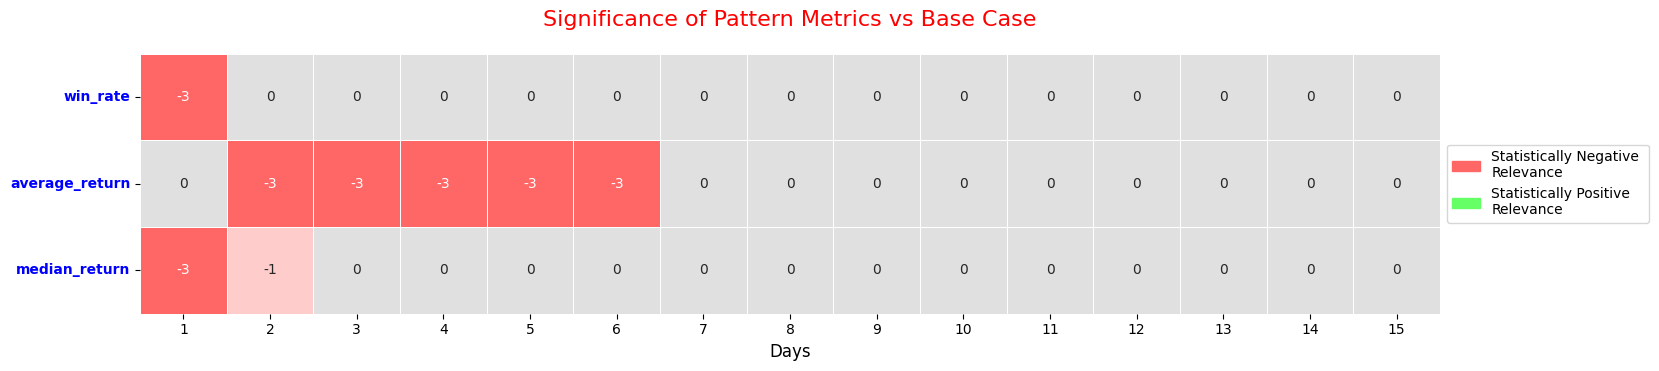

In [31]:
import matplotlib.patches as mpatches

df = pd.DataFrame(table).T  # Transpose the DataFrame to have metrics as rows and days as columns
df.columns = range(1, 16)  # Set column names to be 1-15

# Create a custom colormap with 7 distinct colors
colors = ['#FF6666', '#FF9999', '#FFCCCC', '#E0E0E0', '#CCFFCC', '#99FF99', '#66FF66']
cmap = sns.color_palette(colors, as_cmap=True)

# Create the figure with more space
plt.figure(figsize=(17, 8))

# Create the heatmap
ax = sns.heatmap(df, 
                 annot=True,    # Show the values in each cell
                 cmap=cmap,     # Use our custom colormap
                 center=0,      # Center the colormap at 0
                 fmt="d",       # Use integer format for the annotations
                 cbar=False,    # Remove the color bar
                 linewidths=0.5,
                 square=True,   # Make cells square-shaped
                 vmin=-3, vmax=3    # Set the color scale limits
                 )

plt.title("Significance of Pattern Metrics vs Base Case", fontsize=16, color='red', pad=20)
plt.xlabel("Days", fontsize=12)

# Remove y-axis label
plt.ylabel("")

# Color the y-tick labels blue
plt.yticks(color='blue', fontweight='bold')

# Adjust x-axis labels
plt.xticks(rotation=0)

# Create a custom legend
red_patch = mpatches.Patch(color='#FF6666', label='Statistically Negative \nRelevance')
green_patch = mpatches.Patch(color='#66FF66', label='Statistically Positive \nRelevance')
plt.legend(handles=[red_patch, green_patch], loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent cutoff
plt.tight_layout()

# Add extra space to the right for the legend
plt.subplots_adjust(right=0.85)

plt.show()

This heatmap provides a powerful tool for assessing the effectiveness of the Bullish Engulfing pattern, allowing us to quickly identify when and how the pattern's performance differs significantly from random chance.